In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
from learningratefinder import LearningRateFinder
from clr_callback import CyclicLR

In [3]:
# Set file paths for train and predict datasets
train_file = 'DataSet/Data_Train.xlsx'
predict_file = 'DataSet/Data_Test.xlsx'

In [4]:
# Extract train/predict data from spreadsheet into pandas dataframes
train_df = pd.read_excel(train_file)
predict_df = pd.read_excel(predict_file)

In [5]:
# Get numeric value from "Delivery_Time" field in train data
train_df['Del_Time'] = train_df['Delivery_Time'].apply(lambda x: pd.to_numeric(x.split('minutes')[0].strip()))
train_df['Del_Time_enc'] = train_df['Del_Time'].factorize()[0]
train_df.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,Del_Time,Del_Time_enc
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12,4,30 minutes,30,0
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11,4,30 minutes,30,0
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99,30,65 minutes,65,1
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176,95,30 minutes,30,0
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521,235,65 minutes,65,1


In [6]:
train_df.groupby(['Del_Time', 'Del_Time_enc']).size().reset_index().rename(columns={0:'count'})

,Del_Time,Del_Time_enc,count
0,10,3,4
1,20,4,20
2,30,0,7406
3,45,2,2665
4,65,1,923
5,80,6,14
6,120,5,62


In [7]:
# Extract "Del_Time" field from train_df into NumPy array
train_y = np.array([train_df['Del_Time_enc'].values]).T
train_df.drop(['Del_Time', 'Delivery_Time', 'Del_Time_enc'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))
print("Sample train_y data: \n{}".format(train_y[0:10,:]))

train_y: (11094, 1)
Sample train_y data: 
[[0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [2]
 [0]
 [1]]


In [8]:
# Combine the train and predict dataframes
combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
print("combined_df: {}".format(combined_df.shape))

combined_df: (13868, 8)


In [9]:
# Read location analysis data
loc_analysis_df = pd.read_excel("Location_Analysis.xlsx")
loc_analysis_df.head()

,Location,State,City,Area
0,"FTI College, Law College Road, Pune",Maharashtra,Pune,"FTI College, Law College Road"
1,"Sector 3, Marathalli",Karnataka,Bangalore,"Sector 3, Marathalli"
2,Mumbai Central,Maharashtra,Mumbai,Mumbai Central
3,"Sector 1, Noida",New Delhi,Noida,Sector 1
4,"Rmz Centennial, I Gate, Whitefield",Karnataka,Bangalore,"Rmz Centennial, I Gate, Whitefield"


In [10]:
# Derive "State", "City" and "Area" based on "Location" field
combined_df['State'] = combined_df['Location'].apply(lambda x: loc_analysis_df[loc_analysis_df['Location'] == x]['State'].max(axis=0))
combined_df['City'] = combined_df['Location'].apply(lambda x: loc_analysis_df[loc_analysis_df['Location'] == x]['City'].max(axis=0))
combined_df['Area'] = combined_df['Location'].apply(lambda x: loc_analysis_df[loc_analysis_df['Location'] == x]['Area'].max(axis=0))
combined_df.drop(['Location'], inplace=True, axis=1)
print("combined_df: {}".format(combined_df.shape))

combined_df: (13868, 10)


In [11]:
# Convert "State" field to one-hot encoding
dummy_df = pd.get_dummies(combined_df['State'], prefix='State')
combined_df = pd.concat([combined_df, dummy_df], axis=1)
combined_df.drop(['State'], inplace=True, axis=1)
print("combined_df: {}".format(combined_df.shape))

combined_df: (13868, 14)


In [12]:
# Convert "City" field to one-hot encoding
dummy_df = pd.get_dummies(combined_df['City'], prefix='City')
combined_df = pd.concat([combined_df, dummy_df], axis=1)
combined_df.drop(['City'], inplace=True, axis=1)
print("combined_df: {}".format(combined_df.shape))

combined_df: (13868, 24)


In [13]:
# Column encoding for "Area" field
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 1), stop_words='english', max_features=10000)
features = tfidf.fit_transform(combined_df.Area).toarray()
features_df = pd.DataFrame(features, columns=tfidf.get_feature_names())
combined_df = pd.merge(combined_df, features_df, left_index=True, right_index=True)
combined_df.drop(['Area'], inplace=True, axis=1)
print("combined_df: {}".format(combined_df.shape))

combined_df: (13868, 94)


In [14]:
# Convert "Cuisines" field into categorical encoded individual fields
combined_df['Cuisine_List'] = combined_df['Cuisines'].apply(lambda x: x.split(', '))
combined_df = combined_df.drop('Cuisine_List', 1).join(combined_df.Cuisine_List.str.join('|').str.get_dummies())
combined_df.drop(['Cuisines'], inplace=True, axis=1)
print("combined_df: {}".format(combined_df.shape))

combined_df: (13868, 194)


In [15]:
# Fill invalid string value in "Average_Cost" field with mean value
combined_df['Avg_Cost'] = combined_df['Average_Cost'].apply(lambda x: np.nan if x == 'for' else x)
mean_cost = combined_df['Avg_Cost'].mean()
combined_df['Avg_Cost'] = combined_df['Avg_Cost'].fillna(mean_cost)
combined_df.drop(['Average_Cost'], inplace=True, axis=1)
print("combined_df: {}".format(combined_df.shape))

combined_df: (13868, 194)


In [16]:
# Fill invalid string value in "Rating" field based on below rule:
# 1) If ['NEW','Opening Soon','Temporarily Closed'] then 0
# 2) If '-', then NaN
combined_df['modified_rating'] = combined_df['Rating'].apply(lambda x: np.nan if x == '-' else (0 if x in ['NEW','Opening Soon','Temporarily Closed'] else pd.to_numeric(x)))
mean_rating = combined_df['modified_rating'].mean()
combined_df['modified_rating'] = combined_df['modified_rating'].fillna(mean_rating)
combined_df.drop(['Rating'], inplace=True, axis=1)
print("combined_df: {}".format(combined_df.shape))

combined_df: (13868, 194)


In [17]:
# Fill invalid string value in "Votes" field with mean value
combined_df['modified_votes'] = combined_df['Votes'].apply(lambda x: np.nan if x == '-' else pd.to_numeric(x))
mean_cost = combined_df['modified_votes'].mean()
combined_df['modified_votes'] = combined_df['modified_votes'].fillna(mean_cost)
combined_df.drop(['Votes'], inplace=True, axis=1)
print("combined_df: {}".format(combined_df.shape))

combined_df: (13868, 194)


In [18]:
# Fill invalid string value in "Reviews" field with mean value
combined_df['modified_reviews'] = combined_df['Reviews'].apply(lambda x: np.nan if x == '-' else pd.to_numeric(x))
mean_cost = combined_df['modified_reviews'].mean()
combined_df['modified_reviews'] = combined_df['modified_reviews'].fillna(mean_cost)
combined_df.drop(['Reviews'], inplace=True, axis=1)
print("combined_df: {}".format(combined_df.shape))

combined_df: (13868, 194)


In [19]:
combined_df.drop(['Restaurant'], inplace=True, axis=1)
print("combined_df: {}".format(combined_df.shape))

combined_df: (13868, 193)


In [20]:
# Check if any column has NaN value in dataframe
print("Column with NaN value: {}".format(combined_df.columns[combined_df.isnull().any()].tolist()))

Column with NaN value: []


In [21]:
# Segregate combined_df into train/predict datasets
train_x = combined_df[:11094]
predict_x = combined_df[11094:]

In [22]:
print(train_x.shape)
print(predict_x.shape)

(11094, 193)
(2774, 193)


In [23]:
# Scale the train_x/predict_x datasets
scaler_x = RobustScaler().fit(train_x)
train_x = scaler_x.transform(train_x)
predict_x = scaler_x.transform(predict_x)

In [24]:
# Handling class imbalance
sm = SMOTE(k_neighbors=1)
sm_x, sm_y = sm.fit_sample(train_x, train_y.ravel())
train_x = sm_x
train_y = np.array([sm_y]).T
print("Class balancing done.")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

Class balancing done.
train_x shape: (51842, 193)
train_y shape: (51842, 1)


In [25]:
# Split training data into train/validation/test datasets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=1)
for train_index, validation_index in sss.split(train_x, train_y):
    train_x, validation_x = train_x[train_index], train_x[validation_index]
    train_y, validation_y = train_y[train_index], train_y[validation_index]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, test_index in sss.split(train_x, train_y):
    train_x, test_x = train_x[train_index], train_x[test_index]
    train_y, test_y = train_y[train_index], train_y[test_index]

In [26]:
print("------------------------- Training Dataset -------------------------")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

print("\n------------------------- Validation Dataset -------------------------")
print("validation_x shape: {}".format(validation_x.shape))
print("validation_y shape: {}".format(validation_y.shape))

print("\n------------------------- Test Dataset -------------------------")
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

------------------------- Training Dataset -------------------------
train_x shape: (35252, 193)
train_y shape: (35252, 1)

------------------------- Validation Dataset -------------------------
validation_x shape: (7777, 193)
validation_y shape: (7777, 1)

------------------------- Test Dataset -------------------------
test_x shape: (8813, 193)
test_y shape: (8813, 1)


In [27]:
# Convert train_y/validation_y/test_y into one-hot encode matrix
train_y = tf.keras.utils.to_categorical(train_y, 7)
validation_y = tf.keras.utils.to_categorical(validation_y, 7)
test_y = tf.keras.utils.to_categorical(test_y, 7)

In [28]:
print("------------------------- Training Dataset -------------------------")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

print("\n------------------------- Validation Dataset -------------------------")
print("validation_x shape: {}".format(validation_x.shape))
print("validation_y shape: {}".format(validation_y.shape))

print("\n------------------------- Test Dataset -------------------------")
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

------------------------- Training Dataset -------------------------
train_x shape: (35252, 193)
train_y shape: (35252, 7)

------------------------- Validation Dataset -------------------------
validation_x shape: (7777, 193)
validation_y shape: (7777, 7)

------------------------- Test Dataset -------------------------
test_x shape: (8813, 193)
test_y shape: (8813, 7)


In [83]:
def nn_model(input_shape, c):
    """
    This function is used to train the NN model and get optimal model parameters.
    :param input_shape: Shape of input image
    :param c: Number of classes
    :return: Keras NN Model
    """
    
    # Input Layer
    x_input = Input(shape=(input_shape, ), name='INPUT')
    
    # Fully-connected Layer 1
    x = Dense(units=256, name='FC-1', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x_input)
    x = BatchNormalization(name='BN_FC-1')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-1')(x)
    
    # Fully-connected Layer 2
    x = Dense(units=256, name='FC-2', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-2')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-2')(x)
    
    # Fully-connected Layer 3
    x = Dense(units=512, name='FC-3', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-3')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-3')(x)
    
    # Fully-connected Layer 4
    x = Dense(units=512, name='FC-4', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-4')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-4')(x)
    
    # Fully-connected Layer 5
    x = Dense(units=1024, name='FC-5', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-5')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-5')(x)
    
    # Fully-connected Layer 6
    x = Dense(units=1024, name='FC-6', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-6')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-6')(x)
    
    # Fully-connected Layer 7
    x = Dense(units=512, name='FC-7', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-7')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-7')(x)
    
    # Fully-connected Layer 8
    x = Dense(units=512, name='FC-8', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-8')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-8')(x)
    
    # Fully-connected Layer 9
    x = Dense(units=256, name='FC-9', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-9')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-9')(x)
    
    # Fully-connected Layer 10
    x = Dense(units=256, name='FC-10', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-10')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-10')(x)
    
    # Fully-connected Layer 11
    x = Dense(units=128, name='FC-11', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-11')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-11')(x)
    
    # Fully-connected Layer 12
    x = Dense(units=128, name='FC-12', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-12')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-12')(x)
    
    # Fully-connected Layer 13
    x = Dense(units=64, name='FC-13', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-13')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-13')(x)
    
    # Fully-connected Layer 14
    x = Dense(units=64, name='FC-14', activation='relu', kernel_initializer=he_uniform(seed=1), kernel_regularizer=l2(0.1))(x)
    x = BatchNormalization(name='BN_FC-14')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-14')(x)
    
    # Output Layer
    x = Dense(units=c, activation='softmax', name='OUTPUT', kernel_initializer=he_uniform(seed=1))(x)

    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='BooksPricePredictor')

    return model

In [76]:
# Define the model hyperparameters
max_iterations = 10
mini_batch_size = 128
min_lr = 1e-4
max_lr = 1e-2
step_size = 8 * (train_x.shape[0] // mini_batch_size)
#step_size = 500
clr_method = 'triangular2'

In [79]:
# Create the model
model = nn_model(train_x.shape[1], 7)

# Compile model to configure the learning process
adam = Adam(lr=min_lr)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Triangular learning rate policy
clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, mode=clr_method, step_size=step_size)

Train on 35252 samples
Epoch 1/8
35252/35252 [==============================] - 61s 2ms/sample - loss: 1078.3935 - accuracy: 0.14288s
Epoch 2/8
35252/35252 [==============================] - 47s 1ms/sample - loss: 1078.3793 - accuracy: 0.1400
Epoch 3/8
35252/35252 [==============================] - 45s 1ms/sample - loss: 1077.8498 - accuracy: 0.1380
Epoch 4/8
35252/35252 [==============================] - 43s 1ms/sample - loss: 1065.0064 - accuracy: 0.1427
Epoch 5/8
35252/35252 [==============================] - 47s 1ms/sample - loss: 826.8321 - accuracy: 0.1424
Epoch 6/8
35252/35252 [==============================] - 47s 1ms/sample - loss: 92.4694 - accuracy: 0.2732
Epoch 7/8
28672/35252 [=======================>......] - ETA: 8s - loss: 28.9540 - accuracy: 0.2966

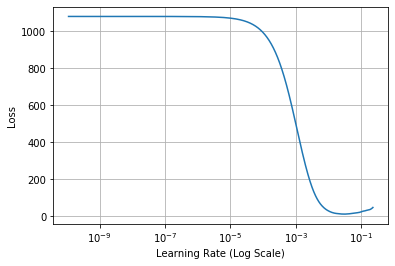

In [78]:
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find((train_x, train_y),
         startLR=1e-10, endLR=1e+1,
         stepsPerEpoch=np.ceil((len(train_x) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()

In [80]:
history = model.fit(x=train_x, y=train_y, batch_size=mini_batch_size,
                    epochs=100, verbose=1,
                    callbacks=[clr], workers=5,
                    validation_data=(validation_x, validation_y))

Train on 35252 samples, validate on 7777 samples
Epoch 1/100
35252/35252 [==============================] - 67s 2ms/sample - loss: 511.1468 - accuracy: 0.1492 - val_loss: 63.7585 - val_accuracy: 0.1429
Epoch 2/100
35252/35252 [==============================] - 55s 2ms/sample - loss: 14.6760 - accuracy: 0.3868 - val_loss: 4.5715 - val_accuracy: 0.1429
Epoch 3/100
35252/35252 [==============================] - 54s 2ms/sample - loss: 3.7714 - accuracy: 0.5004 - val_loss: 4.6180 - val_accuracy: 0.3005
Epoch 4/100
35252/35252 [==============================] - 56s 2ms/sample - loss: 4.6865 - accuracy: 0.4795 - val_loss: 5.1871 - val_accuracy: 0.4283
Epoch 5/100
35252/35252 [==============================] - 54s 2ms/sample - loss: 5.8022 - accuracy: 0.4452 - val_loss: 5.7571 - val_accuracy: 0.3834
Epoch 6/100
35252/35252 [==============================] - 54s 2ms/sample - loss: 6.8290 - accuracy: 0.4187 - val_loss: 11.2783 - val_accuracy: 0.2433
Epoch 7/100
35252/35252 [=====================

Epoch 55/100
35252/35252 [==============================] - 38s 1ms/sample - loss: 1.7012 - accuracy: 0.5210 - val_loss: 1.6331 - val_accuracy: 0.5376
Epoch 56/100
35252/35252 [==============================] - 37s 1ms/sample - loss: 1.8722 - accuracy: 0.5150 - val_loss: 2.3173 - val_accuracy: 0.2970
Epoch 57/100
35252/35252 [==============================] - 38s 1ms/sample - loss: 1.7985 - accuracy: 0.5192 - val_loss: 1.5421 - val_accuracy: 0.5401
Epoch 58/100
35252/35252 [==============================] - 41s 1ms/sample - loss: 1.7695 - accuracy: 0.5223 - val_loss: 1.4880 - val_accuracy: 0.5654
Epoch 59/100
35252/35252 [==============================] - 41s 1ms/sample - loss: 1.5847 - accuracy: 0.5279 - val_loss: 1.4011 - val_accuracy: 0.5790
Epoch 60/100
35252/35252 [==============================] - 39s 1ms/sample - loss: 1.5377 - accuracy: 0.5275 - val_loss: 1.3252 - val_accuracy: 0.5741
Epoch 61/100
35252/35252 [==============================] - 41s 1ms/sample - loss: 1.3958 - ac

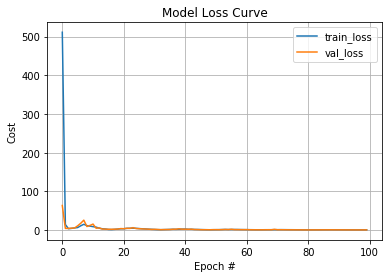

In [81]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Cost')
plt.xlabel('Epoch #')
plt.title("Model Loss Curve")
plt.legend()
plt.grid()
plt.show()

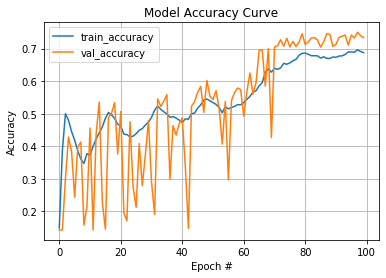

In [82]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.title("Model Accuracy Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(clr.history["lr"])
plt.ylabel('Learning Rate')
plt.xlabel('Iteration #')
plt.title("Cyclical Learning Rate (CLR)")
plt.grid()
plt.show()

In [ ]:
score = model.evaluate(x=test_x, y=test_y, verbose=0)
print('Test loss: {}', format(score[0]))
print('Test accuracy: {}', format(score[1] * 100))

In [ ]:
y_pred = model.predict(test_x)

In [ ]:
predicted_labels = np.array([np.argmax(y_pred, axis=1)]).T
temp_df = pd.DataFrame(predicted_labels, columns=['Class'])
temp_df.groupby(['Class']).size().reset_index().rename(columns={0:'count'})

In [ ]:
y_test = np.array([np.argmax(test_y, axis=1)]).T
f1 = f1_score(y_test, predicted_labels, average='weighted') * 100
accuracy = accuracy_score(y_test, predicted_labels)
print("F1 Score: {}".format(f1))
print("Accuracy: {}".format(accuracy * 100))

In [ ]:
y_pred=model.predict(predict_x)
predicted_labels = np.array([np.argmax(y_pred, axis=1)]).T

In [ ]:
temp_df = pd.DataFrame(predicted_labels, columns=['Class'])
temp_df['Class'] = temp_df['Class'].map({0: 30, 1: 65, 2: 45, 3: 10, 4: 20, 5: 120, 6: 80})
temp_df.groupby(['Class']).size().reset_index().rename(columns={0:'count'})

In [ ]:
submit_df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Food Delivery Time Prediction/Sample_Submission.xlsx")
submit_df.head()

In [ ]:
submit_df['Delivery_Time'] = temp_df['Class'].apply(lambda x: str(x) + " minutes")
submit_df.to_excel("predictions.xlsx", index=False)